<a href="https://colab.research.google.com/github/sanket4776/icici-revenue-leakage-analysis/blob/main/revenue_leakage_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

#Set seed for reproducibility
random.seed(42)
np.random.seed(42)

#Create 20 random customers for testing
customer_ids = range(1, 21)
names = ['Amit', 'Neha', 'Ravi', 'Pooja', 'Ankit', 'Sneha', 'Raj', 'Tina', 'Karan', 'Isha',
         'Vikas', 'Divya', 'Manoj', 'Simran', 'Nitin', 'Riya', 'Alok', 'Sonal', 'Deepak', 'Meera']
segments = ['Retail', 'HNI', 'Corporate']
account_types = ['Savings', 'Current', 'Premium Savings']

customers = pd.DataFrame({
    'customer_id': customer_ids,
    'name': names,
    'segment': [random.choice(segments) for _ in customer_ids],
    'account_type': [random.choice(account_types) for _ in customer_ids],
    'joined_date': [datetime(2020, 1, 1) + timedelta(days=random.randint(0, 1000)) for _ in customer_ids]
})

In [2]:
#Create accounts table for testing
accounts = pd.DataFrame({
    'account_id': range(1001, 1021),
    'customer_id': customer_ids,
    'balance': [round(random.uniform(20000, 200000), 2) for _ in customer_ids],
    'product_type': [random.choice(account_types) for _ in customer_ids],
    'interest_rate': [round(random.uniform(3.0, 5.5), 2) for _ in customer_ids],
    'expected_rate': [4.5 for _ in customer_ids]
})

#Create transaction table for testing atleast 5 transactions per customer
transactions = []
txn_id = 1
for cust_id in customer_ids:
    for _ in range(5):
        txn_type = random.choice(['NEFT', 'IMPS', 'ATM Withdrawal', 'Cheque'])
        amount = round(random.uniform(1000, 50000), 2)
        fee_expected = 0 if txn_type == 'Cheque' else 5
        fee_charged = fee_expected if random.random() > 0.3 else 0  # simulate waiver
        date = datetime(2024, 1, 1) + timedelta(days=random.randint(0, 180))
        transactions.append([txn_id, cust_id, date, txn_type, amount, fee_charged, fee_expected])
        txn_id += 1

transactions = pd.DataFrame(transactions, columns=[
    'txn_id', 'customer_id', 'date', 'type', 'amount', 'fee_charged', 'fee_expected'
])

In [3]:
#Data Preview
print("Customers:")
display(customers.head())

print("Accounts:")
display(accounts.head())

print("Transactions:")
display(transactions.head())


Customers:


,customer_id,name,segment,account_type,joined_date
0,1,Amit,Corporate,Savings,2020-10-11
1,2,Neha,Retail,Premium Savings,2020-06-08
2,3,Ravi,Retail,Premium Savings,2020-08-08
3,4,Pooja,Corporate,Savings,2022-09-07
4,5,Ankit,HNI,Premium Savings,2022-02-20


Accounts:


,account_id,customer_id,balance,product_type,interest_rate,expected_rate
0,1001,1,42468.71,Premium Savings,5.11,4.5
1,1002,2,186013.17,Premium Savings,4.94,4.5
2,1003,3,34184.04,Premium Savings,3.57,4.5
3,1004,4,72772.09,Savings,3.08,4.5
4,1005,5,133155.16,Premium Savings,3.79,4.5


Transactions:


,txn_id,customer_id,date,type,amount,fee_charged,fee_expected
0,1,1,2024-02-05,Cheque,18737.83,0,0
1,2,1,2024-01-29,Cheque,5454.56,0,0
2,3,1,2024-04-18,IMPS,31744.86,5,5
3,4,1,2024-04-29,NEFT,19853.60,5,5
4,5,1,2024-01-03,ATM Withdrawal,48582.84,5,5


Reason for revenue loss for any bank


* Waived off for transaction fees (example : ₹0 charged instead of ₹5)
* Interest income (interest given is more tha interest expected)
* Premium accounts that do not meet MAB thresholds

In [7]:
#Fee leakage through waived charges
waived_fees = transactions[transactions['fee_charged'] < transactions['fee_expected']]

#Calculate leakage per transaction in Bank
waived_fees['fee_leakage'] = waived_fees['fee_expected'] - waived_fees['fee_charged']
total_fee_leakage = waived_fees['fee_leakage'].sum()

print(f"Total fee leakage due to waived/undercharged fees: ₹{total_fee_leakage:.2f}")
waived_fees[['txn_id', 'customer_id', 'type', 'amount', 'fee_charged', 'fee_expected', 'fee_leakage']].head()


Total fee leakage due to waived/undercharged fees: ₹115.00


/tmp/ipython-input-7-2142330342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waived_fees['fee_leakage'] = waived_fees['fee_expected'] - waived_fees['fee_charged']


,txn_id,customer_id,type,amount,fee_charged,fee_expected,fee_leakage
8,9,2,IMPS,25876.40,0,5,5
10,11,3,IMPS,19321.78,0,5,5
21,22,5,IMPS,29833.57,0,5,5
23,24,5,NEFT,26193.65,0,5,5
35,36,8,NEFT,9067.22,0,5,5


In [6]:
#Revenue lost because of intrest mismatch
under_interest = accounts[accounts['interest_rate'] < accounts['expected_rate']].copy()

#Calculate expected vs actual interest per year
under_interest['expected_income'] = (under_interest['balance'] * under_interest['expected_rate']) / 100
under_interest['actual_income'] = (under_interest['balance'] * under_interest['interest_rate']) / 100
under_interest['interest_loss'] = under_interest['expected_income'] - under_interest['actual_income']
total_interest_leakage = under_interest['interest_loss'].sum()

print(f"Total annual interest income leakage: ₹{total_interest_leakage:.2f}")
under_interest[['customer_id', 'balance', 'interest_rate', 'expected_rate', 'interest_loss']].head()


In [10]:
#Premium account non maintainance
recent_txn = pd.merge(transactions, customers[['customer_id', 'account_type']], on='customer_id')
premium_accounts = recent_txn[recent_txn['account_type'] == 'Premium Savings']

last_txn = premium_accounts.groupby('customer_id')['date'].max().reset_index()
inactive_premium = last_txn[last_txn['date'] < pd.to_datetime('2024-07-01') - pd.Timedelta(days=60)]

print(f"Inactive Premium accounts in last 60 days: {inactive_premium.shape[0]}")
inactive_premium


Inactive Premium accounts in last 60 days: 2


,customer_id,date
3,7,2024-04-12
7,14,2024-04-14


In [12]:
#Summary generated till date
print("Revenue Leakage Summary")
print(f"1. Fee Leakage: ₹{total_fee_leakage:.2f}")
print(f"2. Interest Revenue Loss: ₹{total_interest_leakage:.2f}")
print(f"3. Inactive Premium Accounts: {inactive_premium.shape[0]}")


Revenue Leakage Summary
1. Fee Leakage: ₹115.00
2. Interest Revenue Loss: ₹9474.97
3. Inactive Premium Accounts: 2


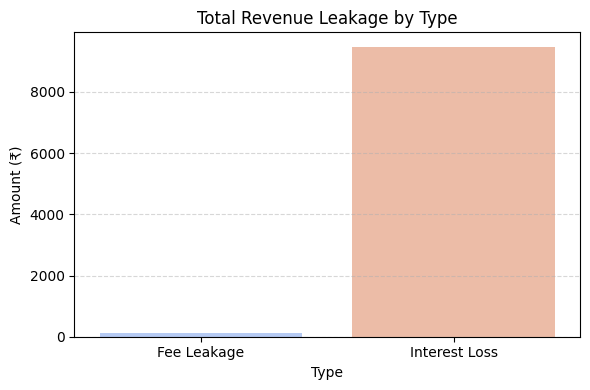

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

leakage_summary = pd.DataFrame({
    'Type': ['Fee Leakage', 'Interest Loss'],
    'Amount': [total_fee_leakage, total_interest_leakage]
})

#Data plotting
plt.figure(figsize=(6,4))
sns.barplot(data=leakage_summary, x='Type', y='Amount', palette='coolwarm')
plt.title('Total Revenue Leakage by Type')
plt.ylabel('Amount (₹)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


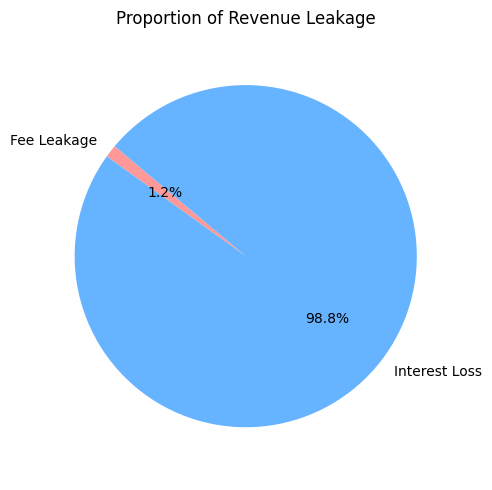

In [14]:
#Pie chart for data loss
plt.figure(figsize=(5,5))
plt.pie(leakage_summary['Amount'], labels=leakage_summary['Type'], autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'], startangle=140)
plt.title('Proportion of Revenue Leakage')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [15]:
#Top 5 customer leaking revenue the most
fee_loss_by_customer = pd.merge(waived_fees, customers[['customer_id', 'name']], on='customer_id')
top_fee_leakage = fee_loss_by_customer.groupby('name')['fee_leakage'].sum().sort_values(ascending=False).head(5)
top_fee_leakage = top_fee_leakage.reset_index()

print("Top 5 Customers:")
top_fee_leakage


Top 5 Customers:


,name,fee_leakage
0,Divya,20
1,Ankit,10
2,Isha,10
3,Tina,10
4,Nitin,10
